# 30 Min - Wash Sq
## Import libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
import gpflow
from gpflow.utilities import print_summary
from sklearn.preprocessing import StandardScaler


## Read in data

In [23]:
# Read data
train = pd.read_csv('../processed_data/train.csv')
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])

# Grab hour interval
train['hour'] = train['tpep_pickup_datetime'].dt.hour
train['half_hour'] = train['tpep_pickup_datetime'].dt.hour + train['tpep_pickup_datetime'].dt.minute / 60
train['half_hour'] = train['half_hour'].round(1)
train = train.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
train['time_index'] = range(1, len(train) + 1)

train.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekend,weekday,hour,half_hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,,,
2022-01-24 00:00:00,14.0,39.98,1543,153.22,218.56,2.00,13,0,2022-01-24 00:00:00,False,0,0,0.0,1
2022-01-24 00:30:00,23.0,51.24,2363,189.50,279.15,2.08,15,0,2022-01-24 00:30:00,False,0,0,0.5,2
2022-01-24 01:00:00,14.0,21.98,745,80.00,127.70,2.36,7,0,2022-01-24 01:00:00,False,0,1,1.0,3
2022-01-24 01:30:00,8.0,14.62,489,54.50,88.21,2.50,5,0,2022-01-24 01:30:00,False,0,1,1.5,4
2022-01-24 02:00:00,13.0,25.03,832,89.50,125.21,1.18,6,0,2022-01-24 02:00:00,False,0,2,2.0,5


In [24]:
# Read data
test = pd.read_csv('../processed_data/test.csv')
test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

# Grab hour interval
test['hour'] = test['tpep_pickup_datetime'].dt.hour
test['half_hour'] = test['tpep_pickup_datetime'].dt.hour + test['tpep_pickup_datetime'].dt.minute / 60
test['half_hour'] = test['half_hour'].round(1)
test = test.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
test['time_index'] = range(1, len(test) + 1)
test.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekend,weekday,hour,half_hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,,,
2024-01-22 00:00:00,44.0,91.34,5361,489.50,747.45,3.070,30,0,2024-01-22 00:00:00,False,0,0,0.0,1
2024-01-22 00:30:00,22.0,57.63,2662,293.93,431.61,3.400,18,0,2024-01-22 00:30:00,False,0,0,0.5,2
2024-01-22 01:00:00,6.0,28.30,652,130.00,179.79,2.495,6,0,2024-01-22 01:00:00,False,0,1,1.0,3
2024-01-22 01:30:00,15.0,34.28,1519,153.00,267.92,2.860,11,0,2024-01-22 01:30:00,False,0,1,1.5,4
2024-01-22 02:00:00,8.0,6.28,626,23.70,44.58,0.000,5,0,2024-01-22 02:00:00,False,0,2,2.0,5


In [25]:
# See data charactertistcs
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10848 entries, 2022-01-24 00:00:00 to 2023-05-15 23:30:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  10848 non-null  float64
 1   trip_distance    10848 non-null  float64
 2   DOLocationID     10848 non-null  int64  
 3   fare_amount      10848 non-null  float64
 4   total_amount     10848 non-null  float64
 5   tip_amount       10848 non-null  float64
 6   pickup_count     10848 non-null  int64  
 7   is_holiday       10848 non-null  int64  
 8   pickup_time      10848 non-null  object 
 9   weekend          10848 non-null  bool   
 10  weekday          10848 non-null  int64  
 11  hour             10848 non-null  int32  
 12  half_hour        10848 non-null  float64
 13  time_index       10848 non-null  int64  
dtypes: bool(1), float64(6), int32(1), int64(5), object(1)
memory usage: 1.1+ MB


In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5424 entries, 2024-01-22 00:00:00 to 2024-05-13 23:30:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  5424 non-null   float64
 1   trip_distance    5424 non-null   float64
 2   DOLocationID     5424 non-null   int64  
 3   fare_amount      5424 non-null   float64
 4   total_amount     5424 non-null   float64
 5   tip_amount       5424 non-null   float64
 6   pickup_count     5424 non-null   int64  
 7   is_holiday       5424 non-null   int64  
 8   pickup_time      5424 non-null   object 
 9   weekend          5424 non-null   bool   
 10  weekday          5424 non-null   int64  
 11  hour             5424 non-null   int32  
 12  half_hour        5424 non-null   float64
 13  time_index       5424 non-null   int64  
dtypes: bool(1), float64(6), int32(1), int64(5), object(1)
memory usage: 577.4+ KB


In [27]:
## SHRINK SIZES IF NECESSARY
#train = train[:1000]
#test = test[:1000]

## EDA

In [28]:
train.groupby('hour')['pickup_count'].mean()

hour
0     54.477876
1     45.699115
2     34.154867
3     19.247788
4      6.216814
5      1.714602
6      3.289823
7      6.046460
8      9.584071
9     12.044248
10    13.557522
11    16.557522
12    20.964602
13    23.431416
14    27.243363
15    29.524336
16    30.455752
17    34.066372
18    39.847345
19    42.106195
20    45.747788
21    57.893805
22    59.159292
23    58.440265
Name: pickup_count, dtype: float64

In [29]:
test.groupby('hour')['pickup_count'].mean()

hour
0     80.199115
1     74.309735
2     54.022124
3     25.256637
4      7.376106
5      1.876106
6      2.902655
7      5.955752
8      9.482301
9     11.057522
10    12.154867
11    15.004425
12    18.986726
13    22.725664
14    25.446903
15    28.681416
16    30.075221
17    33.287611
18    39.672566
19    44.756637
20    50.982301
21    69.194690
22    75.632743
23    80.300885
Name: pickup_count, dtype: float64

## Plot general Time Series

## Over chosen time interval

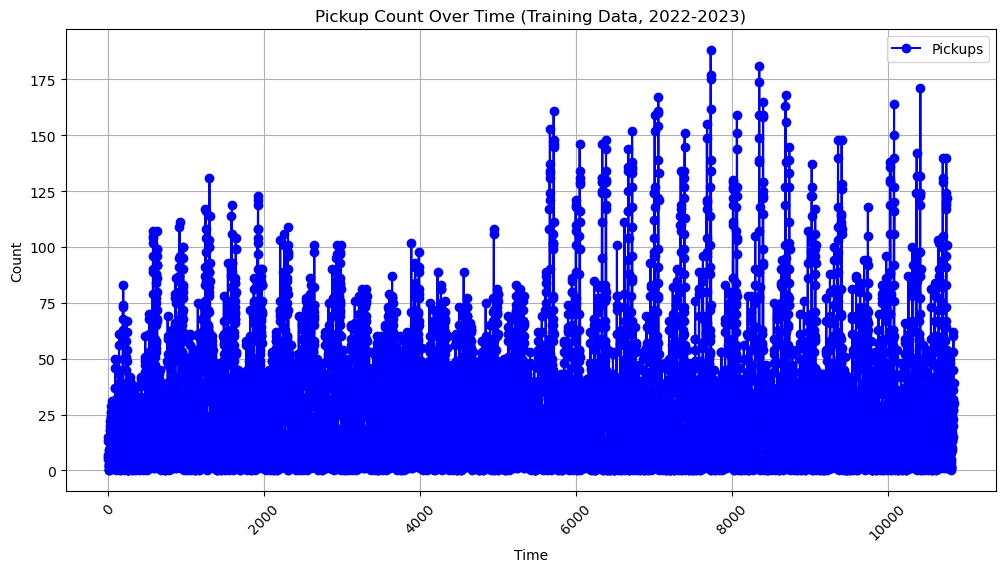

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'], train['pickup_count'], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, 2022-2023)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

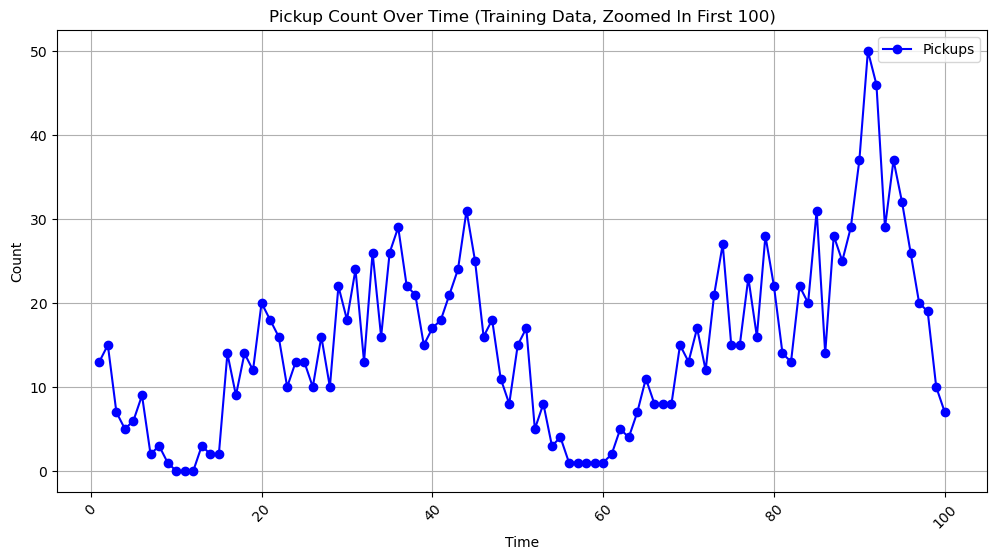

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, Zoomed In First 100)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

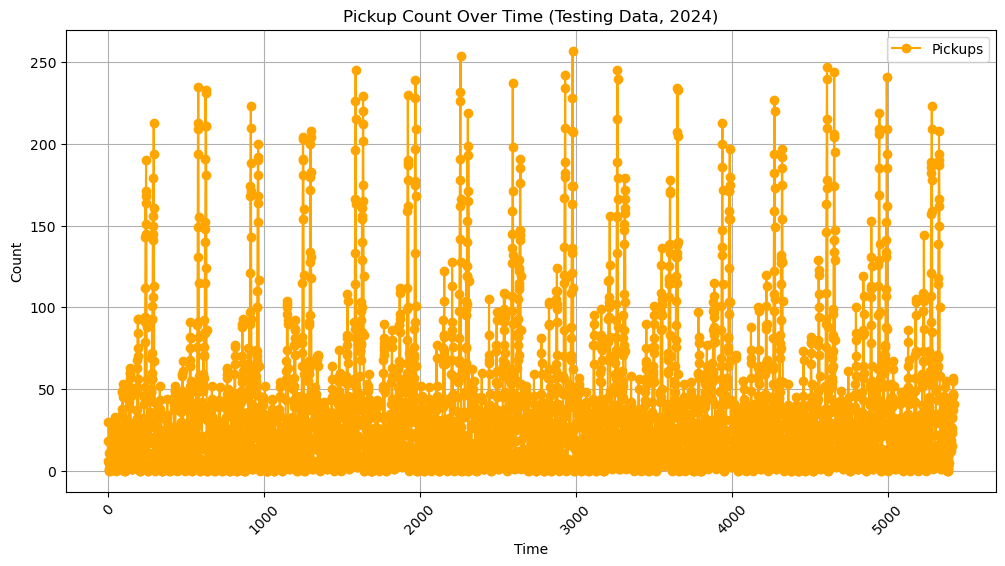

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(test['time_index'], test['pickup_count'], marker='o', label='Pickups', color='orange')
plt.title('Pickup Count Over Time (Testing Data, 2024)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

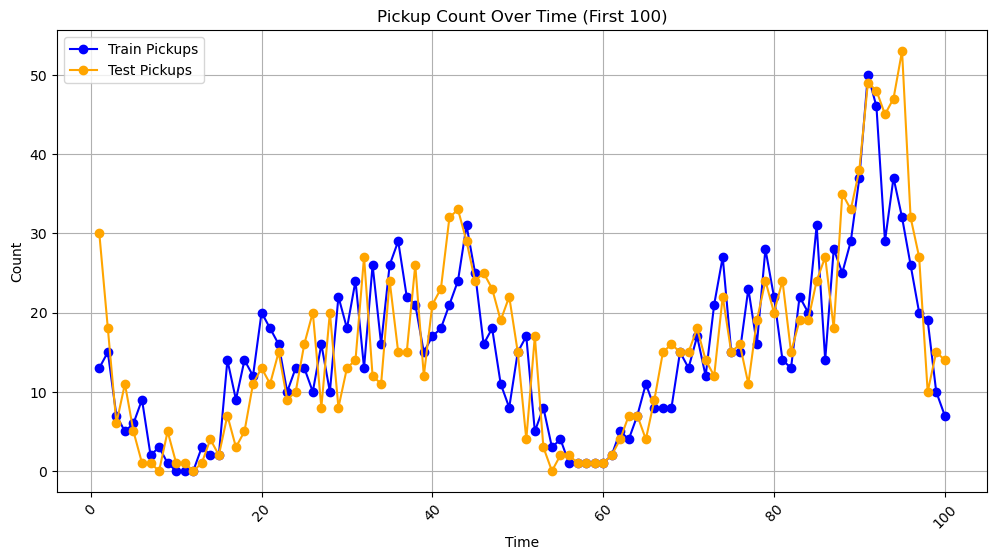

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Train Pickups', color='blue')
plt.plot(test['time_index'][:100], test['pickup_count'][:100], marker='o', label='Test Pickups', color='orange')
plt.title('Pickup Count Over Time (First 100)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## Over the hour

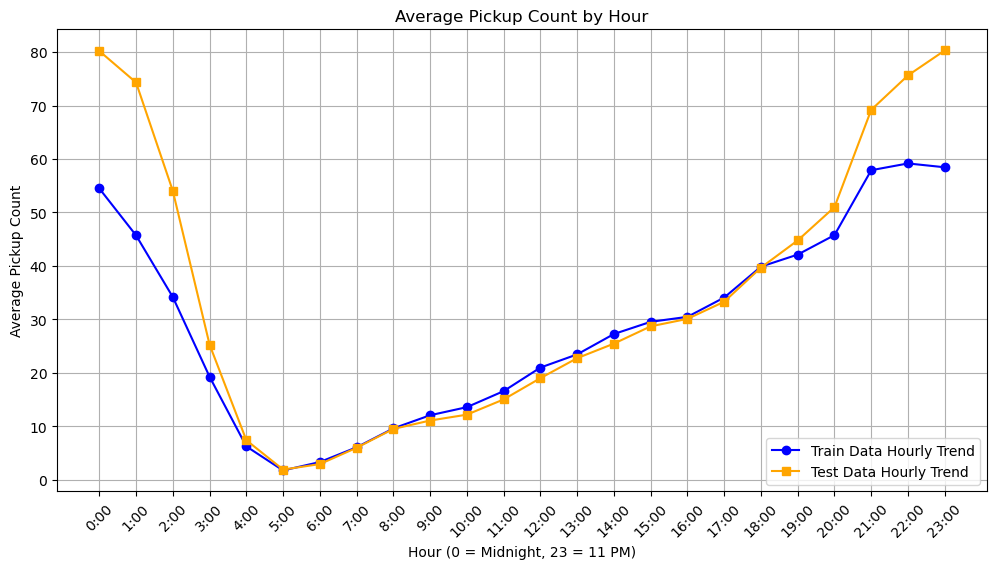

In [34]:
# Group by hour and calculate the mean pickup count for each hour
hourly_trend_train = train.groupby('hour')['pickup_count'].mean()
hourly_trend_test = test.groupby('hour')['pickup_count'].mean()

# Plot hourly trend
plt.figure(figsize=(12, 6))
plt.plot(
    hourly_trend_train.index,
    hourly_trend_train.values,
    marker='o',
    label='Train Data Hourly Trend',
    color='blue'
)
plt.plot(
    hourly_trend_test.index,
    hourly_trend_test.values,
    marker='s',
    label='Test Data Hourly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Hour')
plt.xlabel('Hour (0 = Midnight, 23 = 11 PM)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(0, 24),
    labels=[f'{h}:00' for h in range(0, 24)],  # Formats hour labels as '0:00', '1:00', etc.
    rotation=45
)
plt.grid()
plt.legend()
plt.show()

## Over each weekday

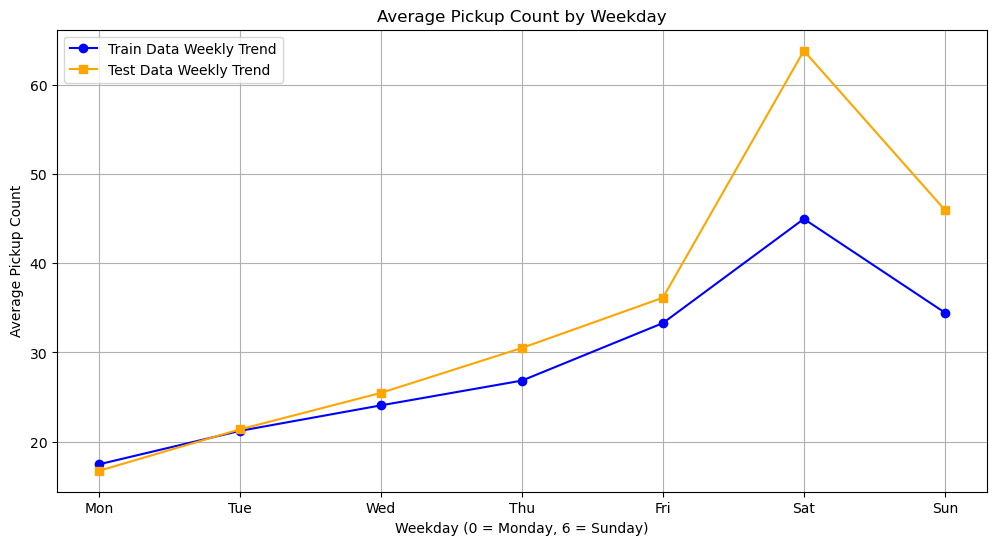

In [35]:
# Group by weekday and calculate the mean pickup count for each weekday
weekly_trend_train = train.groupby('weekday')['pickup_count'].mean()
weekly_trend_test = test.groupby('weekday')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Weekday')
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=weekly_trend_train.index,
    labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
plt.grid()
plt.legend()
plt.show()


## Over the weeks

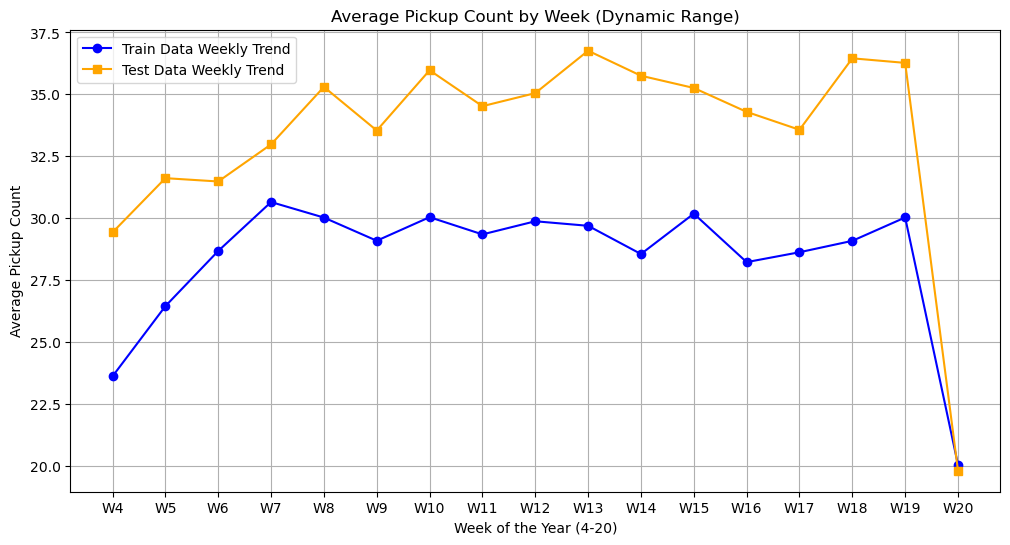

In [36]:
# Group by week of the year and calculate the mean pickup count for each week
train['pickup_time'] = pd.to_datetime(train['pickup_time'])
test['pickup_time'] = pd.to_datetime(test['pickup_time'])
train['week'] = train['pickup_time'].dt.isocalendar().week
test['week'] = test['pickup_time'].dt.isocalendar().week

# Determine the min and max week from both datasets
min_week = min(train['week'].min(), test['week'].min())
max_week = max(train['week'].max(), test['week'].max())

# Group by week for the range of weeks in the data
weekly_trend_train = train.groupby('week')['pickup_count'].mean()
weekly_trend_test = test.groupby('week')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Week (Dynamic Range)')
plt.xlabel(f'Week of the Year ({min_week}-{max_week})')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(min_week, max_week + 1, max(1, (max_week - min_week) // 10)),  # Adjust ticks dynamically
    labels=[f'W{k}' for k in range(min_week, max_week + 1, max(1, (max_week - min_week) // 10))]
)
plt.grid()
plt.legend()
plt.show()


## Over the month

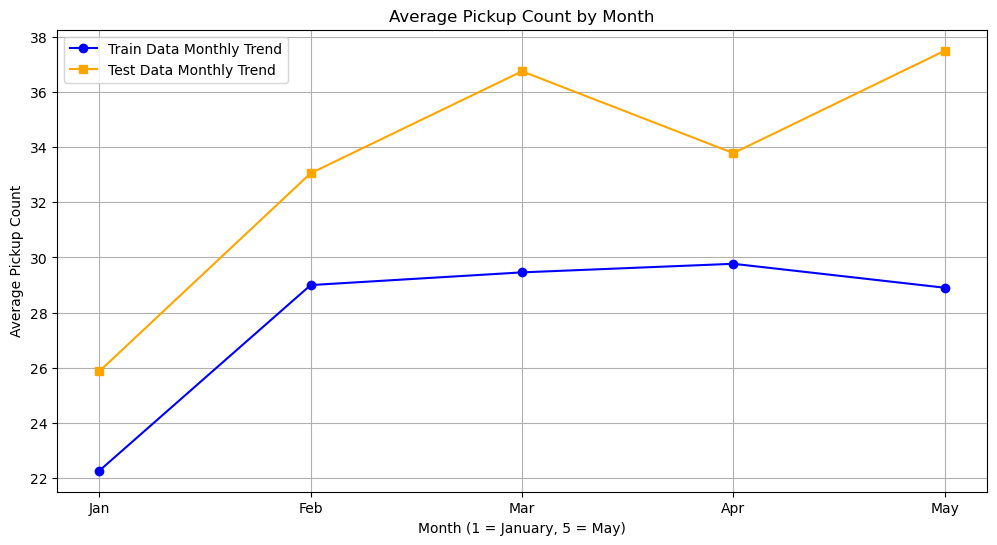

In [37]:
# Group by month and calculate the mean pickup count for each month
monthly_trend_train = train.groupby(train['pickup_time'].dt.month)['pickup_count'].mean()
monthly_trend_test = test.groupby(test['pickup_time'].dt.month)['pickup_count'].mean()

# Plot monthly trend
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_trend_train.index,
    monthly_trend_train.values,
    marker='o',
    label='Train Data Monthly Trend',
    color='blue'
)
plt.plot(
    monthly_trend_test.index,
    monthly_trend_test.values,
    marker='s',
    label='Test Data Monthly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Month')
plt.xlabel('Month (1 = January, 5 = May)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(1, 6),
    labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May'
    ]
)
plt.grid()
plt.legend()
plt.show()


## Model Fitting - try GP

## All vars

In [38]:
# Features (X) - Including the new feature
## Let's try the hstack method
train['year'] = train['pickup_time'].dt.year  # Extract year from pickup_time
train_by_year = [group[['half_hour', 'weekday']].values for _, group in train.groupby('year')]
X_train = np.hstack(train_by_year)[:,0:2]  # Horizontally stack features by year

test['year'] = test['pickup_time'].dt.year  # Extract year from pickup_time
test_by_year = [group[['half_hour', 'weekday']].values for _, group in test.groupby('year')]
X_test = np.hstack(test_by_year)  # Horizontally stack features by year


# X_train
#X_train = train[['hour', 'weekday']].values
#X_test = test[['hour', 'weekday']].values

# Features (X) - All columns except 'pickup_count'
#X_train = train[['hour']].values
#X_test = test[['hour']].values

# Target (y) - 'pickup_count'
# Subtract the mean function (use training data)
train_by_year = [group[['pickup_count']].values for _, group in train.groupby('year')]
y_train = np.hstack(train_by_year).mean(axis=1)  # Horizontally stack features by year

# Target (y)
mean_func = train['pickup_count'].mean()
#y_train = train['pickup_count'].values.astype(np.float64)  # Ensure float64 type for compatibility
y_test = test['pickup_count'].values.astype(np.float64)  # Also ensure float64 for consistenc

# Scale features if necessary (important for GP models to avoid dominance of larger scale features)
## HERE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#print(X_scaled)

In [39]:
X_train

array([[-1.69633458, -1.47869908],
       [-1.62415013, -1.47869908],
       [-1.55196568, -1.47869908],
       ...,
       [ 1.55196568, -1.47869908],
       [ 1.62415013, -1.47869908],
       [ 1.69633458, -1.47869908]])

In [40]:
y_train

array([14. , 14. ,  6.5, ..., 49. , 38.5, 27. ])

In [41]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5424, 2), (5424,), (5424, 2), (5424,))

In [21]:
# GPFlow model
# Combine squared exponential kernel with sinusoidal kernel
squared_exponential = gpflow.kernels.SquaredExponential()
sinusoidal = gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(), period=48)
white_noise = gpflow.kernels.White()
kernel = squared_exponential + sinusoidal + white_noise

# Define the GP regression model
model = gpflow.models.GPR(data=(X_train, y_train.reshape(-1, 1)), kernel=kernel, mean_function=None)

# Optimize the model using Scipy optimizer
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, variables=model.trainable_variables)

# Print the summary of the kernel
print_summary(model)

# Predictions
mean, variance = model.predict_f(X_test)
y_pred = mean.numpy().flatten()
sigma = np.sqrt(variance.numpy()).flatten()

╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].variance                 │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  81.8879   │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].lengthscales             │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   0.220133 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].bas

Root Mean Squared Error: 21.570
MAPE: 431735342392082.500


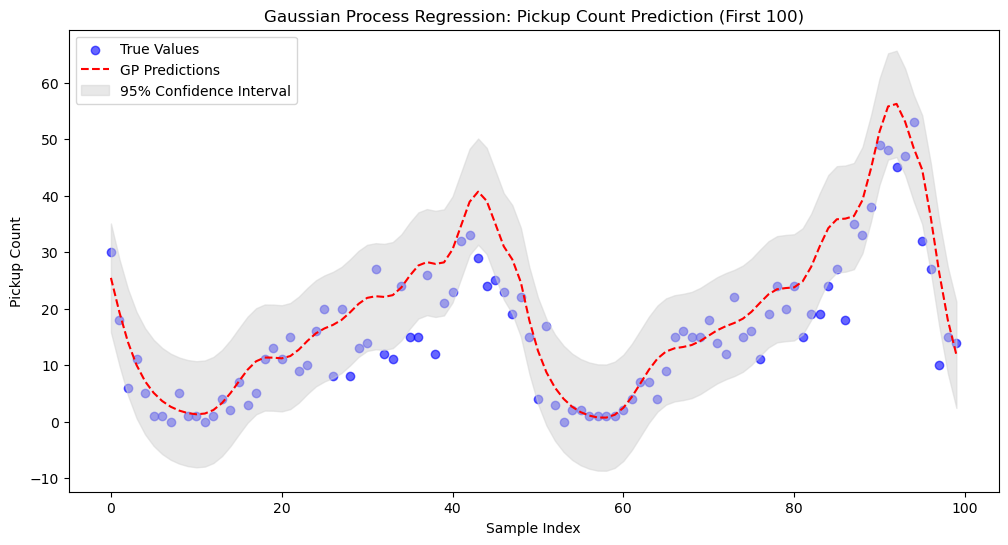

Sigma
4.800510065507245


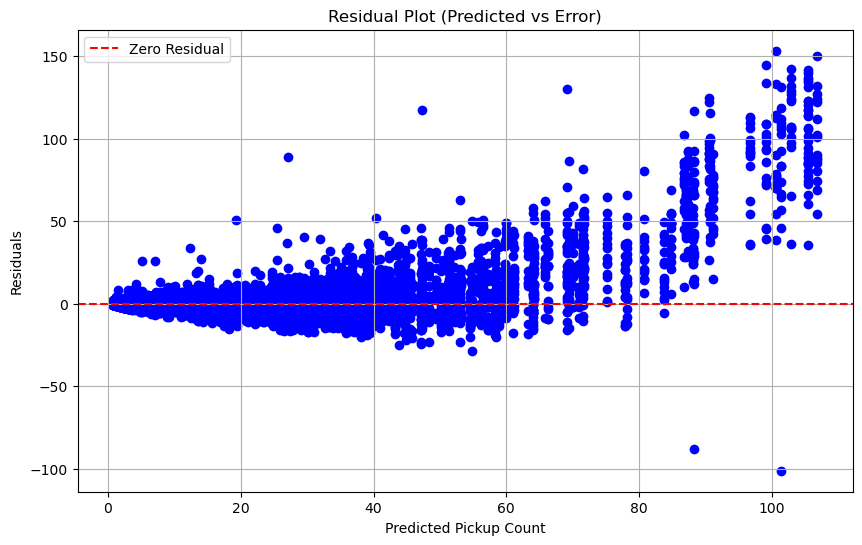

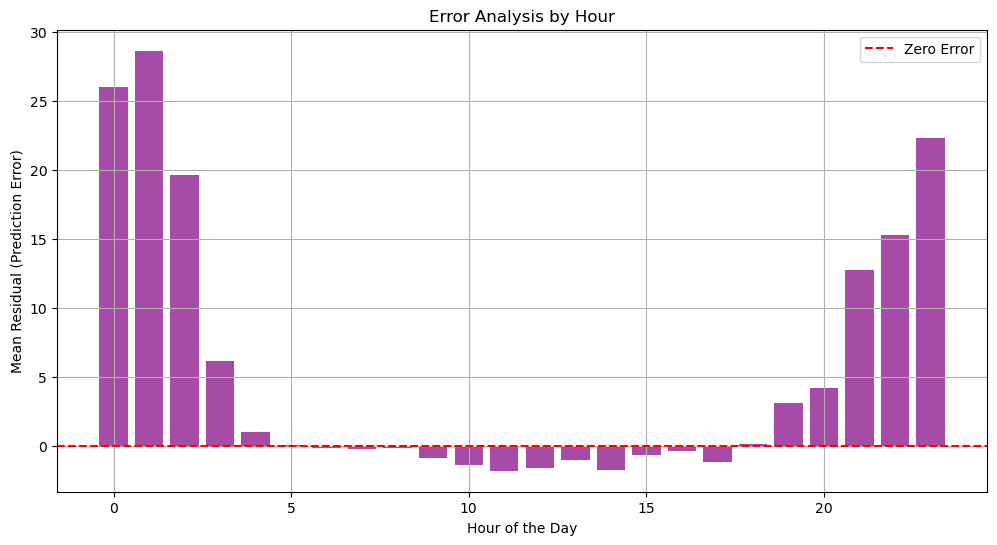

In [22]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# 95% interval mean
#95
print(sigma.mean() * 1.96)

# Sigma
print(sigma.mean())

9.4089997283942
4.800510065507245


Root Mean Squared Error: 21.570
MAPE: 431735342392082.500


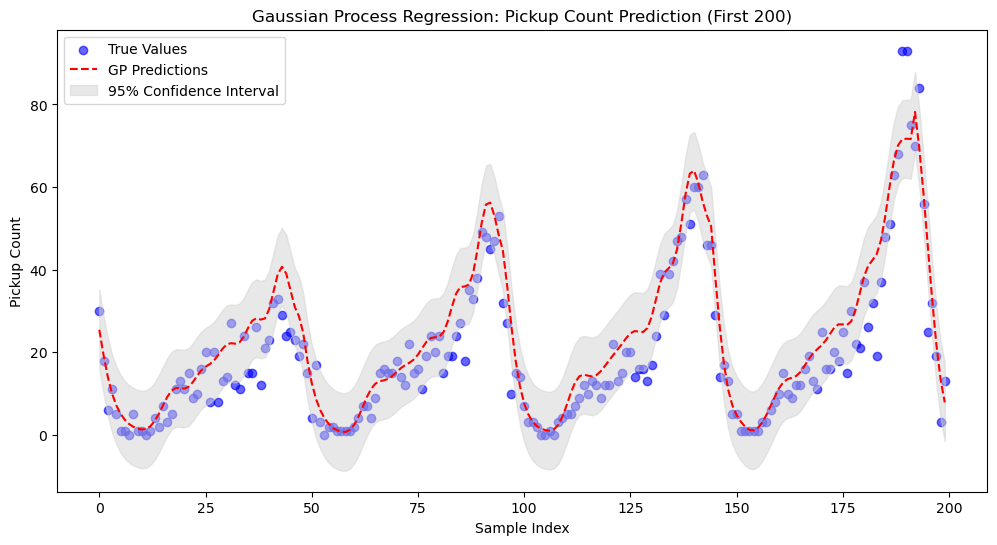

Sigma
4.800510065507245


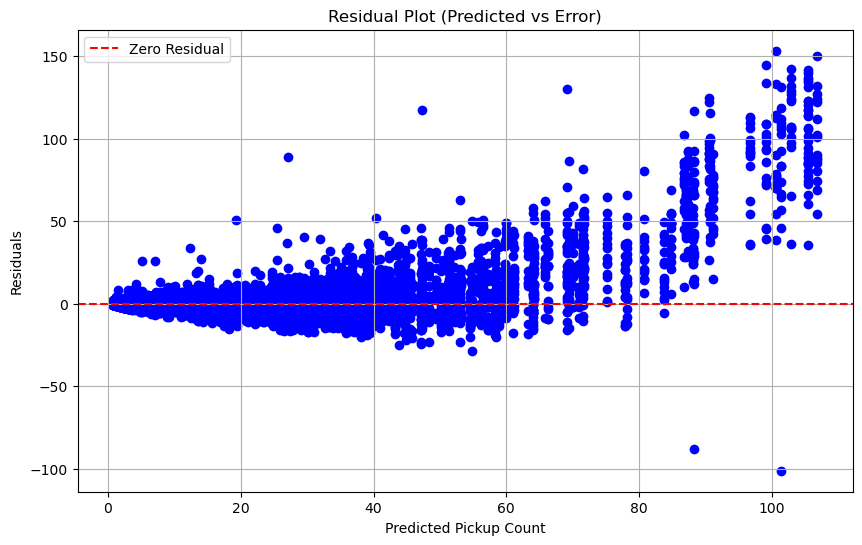

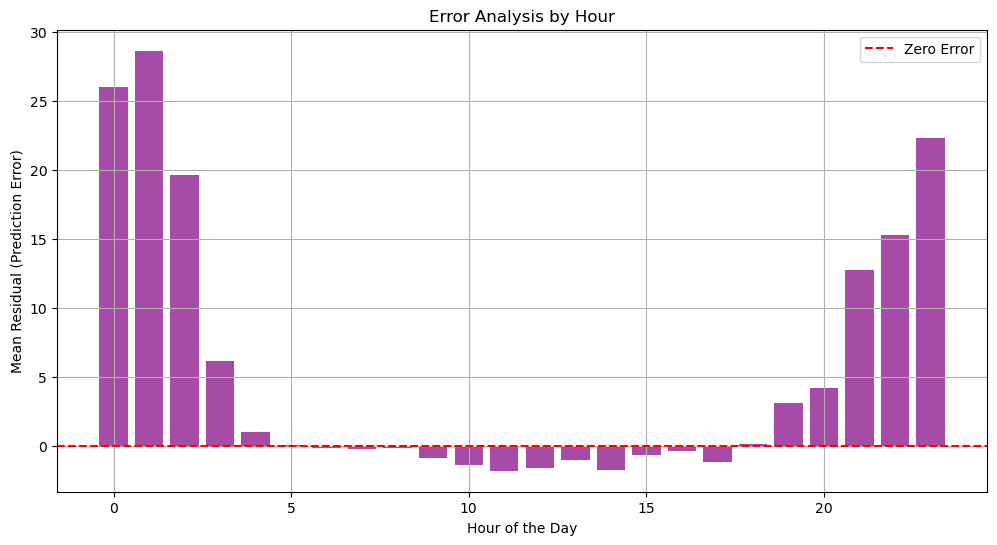

In [28]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:200])), y_test[:200], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:200])), y_pred[:200], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:200])),
    y_pred[:200] - 1.96 * sigma[:200],
    y_pred[:200] + 1.96 * sigma[:200],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 200)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


## Simpler

In [ ]:
# GPFlow model
# Combine squared exponential kernel with sinusoidal kernel
sinusoidal = gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(), period=48)
white_noise = gpflow.kernels.White()
kernel = sinusoidal + white_noise

mean_func = y_train.reshape(-1,1).mean()

# Define the GP regression model
model = gpflow.models.GPR(data=(X_train, (y_train.reshape(-1, 1) - mean_func)), kernel=kernel, mean_function=None)

# Optimize the model using Scipy optimizer
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, variables=model.trainable_variables)

# Print the summary of the kernel
print_summary(model)

# Predictions
mean, variance = model.predict_f(X_test)
y_pred = mean.numpy().flatten() + mean_func
sigma = np.sqrt(variance.numpy()).flatten()

╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 453.62      │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   0.0195758 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels

In [46]:
# Predictions
mean, variance = model.predict_f(X_test)
y_pred = mean.numpy().flatten() + mean_func
sigma = np.sqrt(variance.numpy()).flatten()

Root Mean Squared Error: 21.567
MAPE: 425663950361470.938


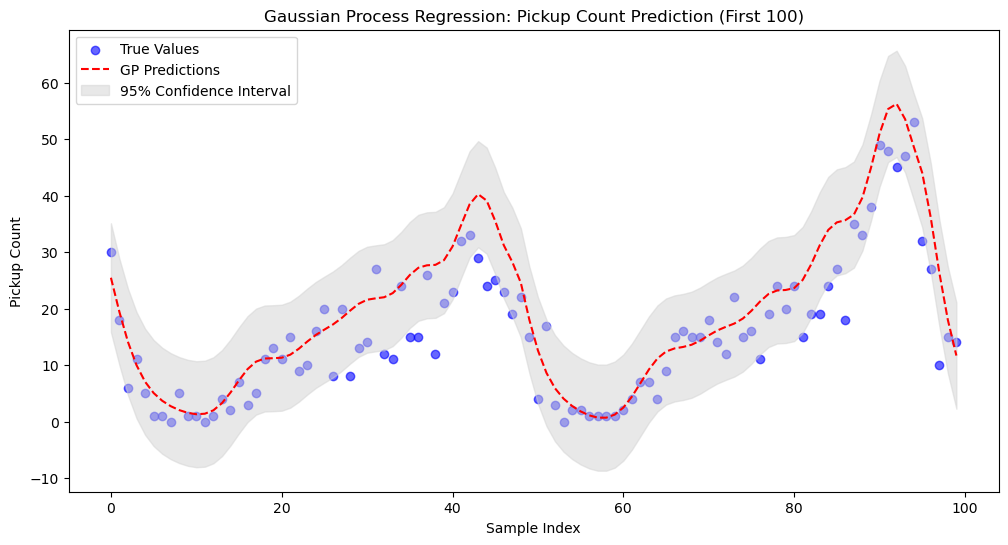

Sigma
4.8011482196364295


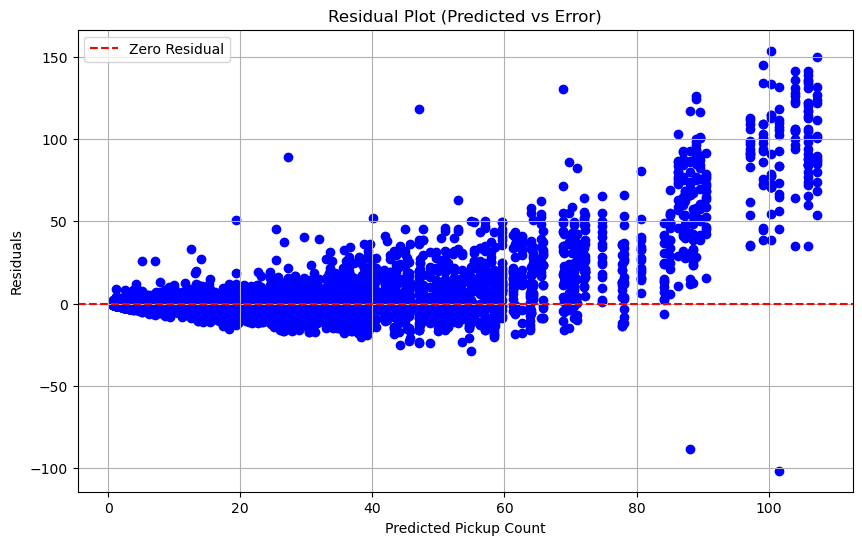

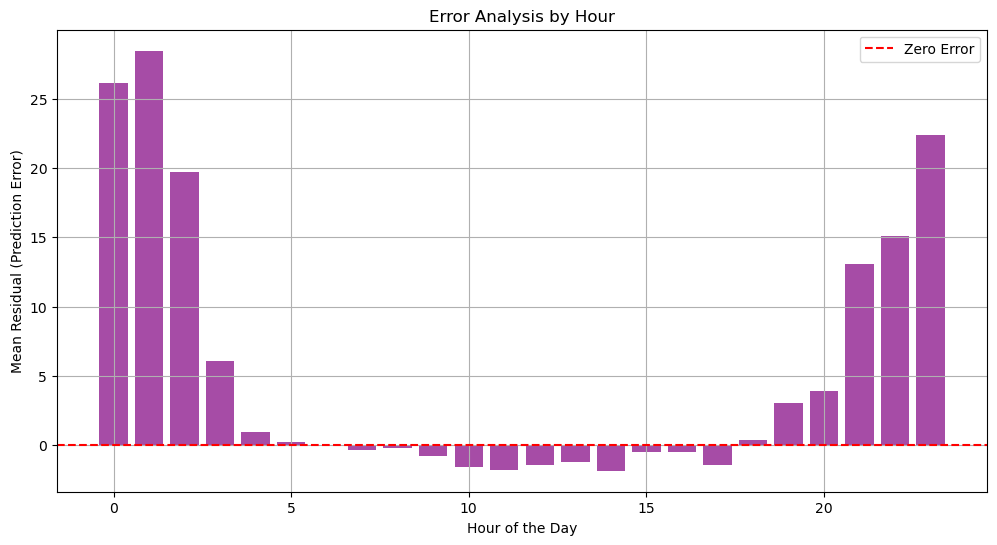

In [ ]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:200])), y_test[:200], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:200])), y_pred[:200], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:200])),
    y_pred[:200] - 1.96 * sigma[:200],
    y_pred[:200] + 1.96 * sigma[:200],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 200)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()

# 95% interval mean
#95
print(sigma.mean() * 1.96)

# Sigma
print(sigma.mean())



Root Mean Squared Error: 21.567
MAPE: 425663950361470.938


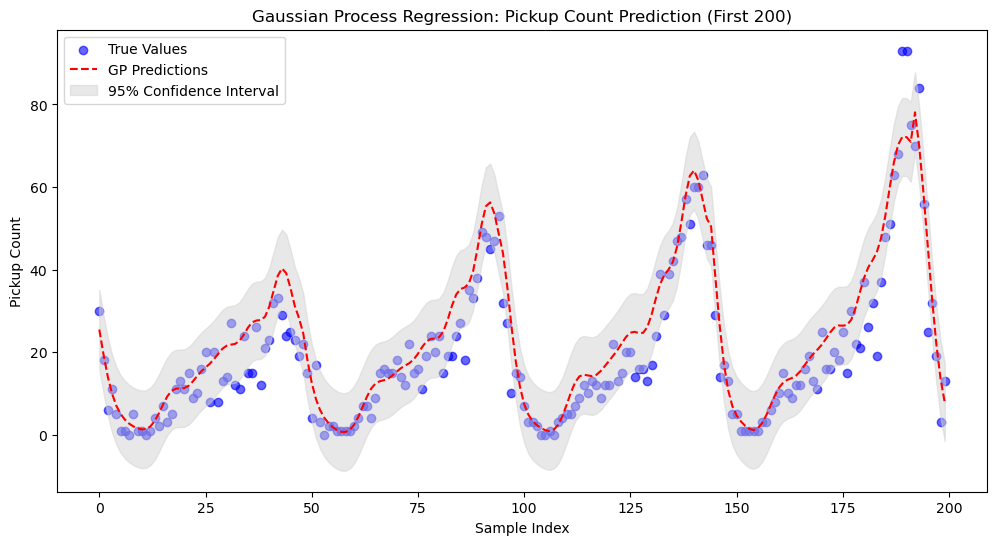

Sigma
4.8011482196364295


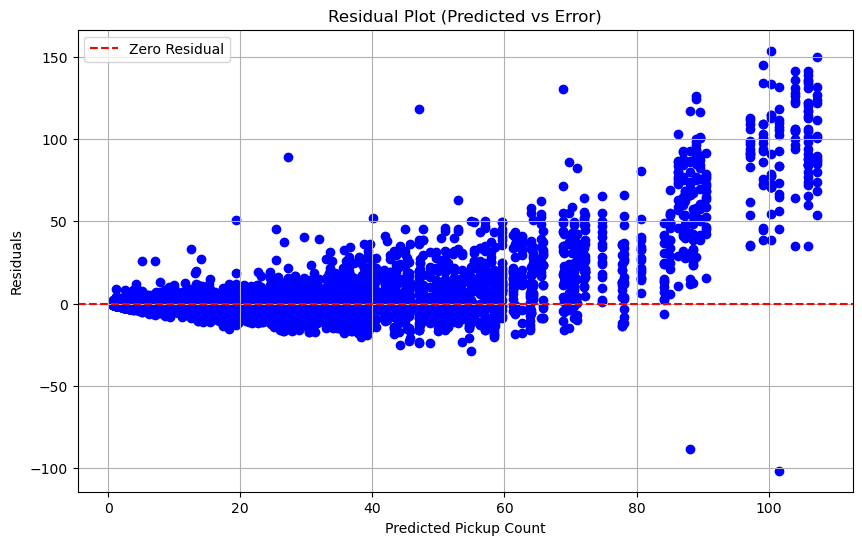

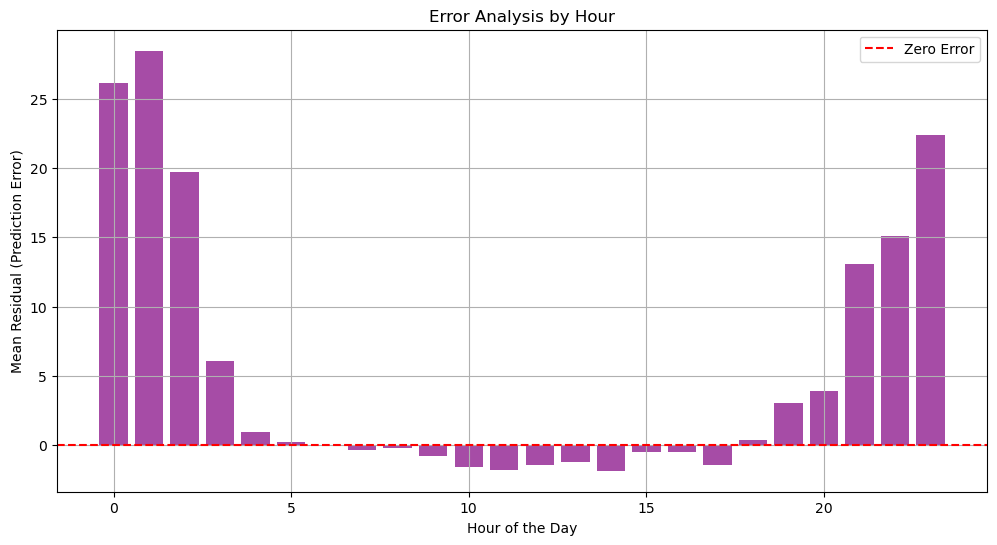

In [ ]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:200])), y_test[:200], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:200])), y_pred[:200], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:200])),
    y_pred[:200] - 1.96 * sigma[:200],
    y_pred[:200] + 1.96 * sigma[:200],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 200)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()

# 95% interval mean
#95
print(sigma.mean() * 1.96)

# Sigma
print(sigma.mean())
